Let's start with clustering all the stances from the left foot only.
The stances are calculated from one feature (the sum of all sensors under the left foot for each patient)

### Importing

In [ ]:
pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 7.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import decomposition

import os

from tqdm.auto import tqdm

from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

import ast

import matplotlib.pyplot as plt
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### Reading Data

In [ ]:
# path of original data folder
data_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data"
csvD_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/csv_files"
demographics = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/demographics.csv"
dem_df = pd.read_csv(demographics)

In [ ]:
# reading the data info file about the left stances
left_stances_level_df= pd.read_csv(data_path + '/data_left_stances.csv')

In [ ]:
left_stances_level_df.head()

,ID,y,level,stances
0,GaPt03,1,3.0,"[660.44, 641.96, 633.49, 610.61, 598.18, 584.6..."
1,GaPt03,1,3.0,"[20.24, 27.83, 45.54, 75.35, 137.94, 189.42, 2..."
2,GaPt03,1,3.0,"[25.3, 40.48, 59.95, 105.82, 169.95, 205.48, 2..."
3,GaPt03,1,3.0,"[27.83, 40.48, 78.76, 162.25, 213.29, 269.83, ..."
4,GaPt03,1,3.0,"[27.83, 45.54, 83.38, 127.05, 172.59, 215.71, ..."


In [ ]:
len(left_stances_level_df['ID'].unique()) # number of different subjects

165

### The last column is saved as string while it is a list, in the following we transform it to list.

In [ ]:
type(left_stances_level_df["stances"][0])

str

In [ ]:
from ast import literal_eval
left_stances_level_df['stances'] =[ast.literal_eval(x) for x in left_stances_level_df['stances'] ]
# t=df.right_stances.apply(lambda s: list(ast.literal_eval(s)))

In [ ]:
type(left_stances_level_df["stances"][0])

list

### Deleting lists shorter than 2 items

In [ ]:
# getting the stances lists
stances = left_stances_level_df['stances']

In [ ]:
stances

0        [660.44, 641.96, 633.49, 610.61, 598.18, 584.6...
1        [20.24, 27.83, 45.54, 75.35, 137.94, 189.42, 2...
2        [25.3, 40.48, 59.95, 105.82, 169.95, 205.48, 2...
3        [27.83, 40.48, 78.76, 162.25, 213.29, 269.83, ...
4        [27.83, 45.54, 83.38, 127.05, 172.59, 215.71, ...
                               ...                        
31273    [20.68, 161.59, 324.72, 473.22, 575.19, 660.33...
31274    [28.93, 185.68, 306.68, 445.83, 532.29, 605.33...
31275    [62.26, 259.82, 396.33, 520.85, 604.01, 642.95...
31276    [22.77, 115.28, 256.3, 361.02, 459.69, 521.51,...
31277    [21.01, 46.42, 65.34, 99.88, 127.27, 152.35, 1...
Name: stances, Length: 31278, dtype: object

In [ ]:
# get the ids of lists that have less than 2 elements
indices = [ id for id,x in enumerate(stances) if len(x)<2 ]

In [ ]:
# All the stances #31278
left_stances_level_df.shape

(31278, 4)

In [ ]:
# drop stances lists that have less than 2 elements
updated_df= left_stances_level_df.drop(indices)

In [ ]:
# Stances with more than 1 vlaue #30595
updated_df.shape

(30263, 4)

Checking all the remaining lists are longer than 2

In [ ]:
stances2 = updated_df['stances']

In [ ]:
indices2 = [ id for id,x in enumerate(stances2) if len(x)<2 ]

In [ ]:
indices2 # there are no lists shorter than 2 in the updated_df dataframe

[]

### Shuffling the dataset

In [ ]:
df = updated_df.sample(frac = 1,random_state=4)

In [ ]:
df.shape

(30263, 4)

In [ ]:
df.head()

,ID,y,level,stances
26561,JuPt23,1,1.0,"[36.08, 280.83, 440.88, 518.98, 637.78, 739.31..."
378,GaPt04,1,2.0,"[26.51, 50.71, 97.57, 157.96, 217.36, 260.59, ..."
19590,JuPt11,1,1.0,"[20.79, 120.34, 431.53, 549.12, 594.99, 612.59..."
24301,JuPt11,1,1.0,"[40.7, 302.72, 458.37, 546.92, 625.79, 671.11,..."
7796,SiCo08,0,0.0,"[33.11, 126.28, 260.15, 480.92, 637.78, 741.95..."


Checking AGAIN that all the stances lists have at least 2 items

In [ ]:
IDs = [ id for id,x in enumerate(df['stances']) if len(x)<2 ]

In [ ]:
len(IDs) # the length is 0 then yes all the stances lists have at least 2 items

0

### Transforming the dataset to a compitable format for the tslearn library.

In [ ]:
X = to_time_series_dataset(df['stances'].to_list())

In [ ]:
len(X)/4

7565.75

### Clustering

In [ ]:
KM_left = TimeSeriesKMeans(n_clusters=2, metric="dtw") # excuting time ~ 1h
clusters_left = KM_left.fit_predict(X[:1000])

### Viaualizing

In [ ]:
predicted={0:[], 1:[]}
for i, v in enumerate(clusters_left):
    predicted[v].append(i)

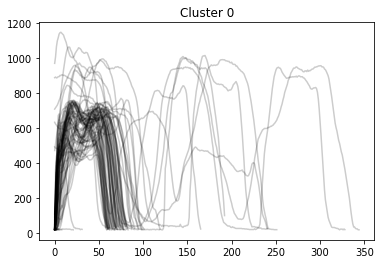

In [ ]:
for label in predicted[0]:
  plt.plot(X[label].ravel(), "k-", alpha=.2)
  #plt.plot(km.cluster_centers_[0].ravel(), "r-")
  plt.title("Cluster 0")

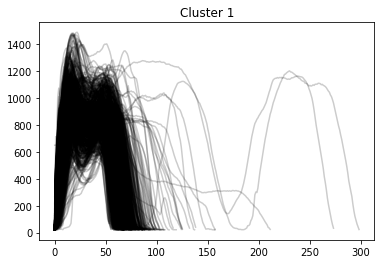

In [ ]:
for label in predicted[1]:
  plt.plot(X[label].ravel(), "k-", alpha=.2)
  #plt.plot(km.cluster_centers_[0].ravel(), "r-")
  plt.title("Cluster 1")

#### Calculate Data Distributions among the clusters

In [ ]:
# the levels of 1000 subjects that were clustered
levels = df['level'][:1000]

In [ ]:
# creating a datafrmae that contains each time series' cluster with the actual PD_level
distriutions = pd.DataFrame(list(zip(clusters_left, levels)),
               columns =['cluster', 'PD_level'])

In [ ]:
distriutions

,cluster,PD_level
0,1,1.0
1,1,2.0
2,1,1.0
3,1,1.0
4,1,0.0
...,...,...
995,1,2.0
996,1,1.0
997,1,0.0
998,1,1.0


In [ ]:
counts = distriutions.pivot_table(index = ['cluster','PD_level'], aggfunc ='size')

In [ ]:
# the counts pivot table shows the count of subjects of each PD level in each cluster
counts

cluster  PD_level
0        0.0          20
         1.0          36
         2.0          16
         3.0          15
1        0.0         275
         1.0         328
         2.0         244
         3.0          66
dtype: int64

In [ ]:
# Calculating the number of each PD level in the clustered data
PD_0 = counts[0][0.0]+counts[1][0.0]
PD_1 = counts[0][1.0]+counts[1][1.0]
PD_2 = counts[0][2.0]+counts[1][2.0]
PD_3 = counts[0][3.0]+counts[1][3.0]

In [ ]:
# the counts from the pivot table `counts`
counts.values

array([ 20,  36,  16,  15, 275, 328, 244,  66])

In [ ]:
# Finding the precentage of each PD level of the count of subjects in each cluster individually 
each_cluster_distribution = list(counts.values[:4]/len(predicted[0])) # predicted[0] is the count of individuals 
each_cluster_distribution+=list(counts.values[4:8]/len(predicted[1]))
each_cluster_distribution = list(np.around(np.array(each_cluster_distribution),2))

In [ ]:
# Find the precentage of each PD level distributed among clusters of the count of each PD level in the 1000 subjects in data
each_level_distribution=8*[0]
for i in range(len(counts.values)-1):
  if (i%4 == 0 ):
    each_level_distribution[i] = counts.values[i]/PD_0
  elif (i%4 == 1 ):
    each_level_distribution[i] = counts.values[i]/PD_1
  elif (i%4 == 2 ):
    each_level_distribution[i] = counts.values[i]/PD_2
  elif (i%4 == 3 ):
    each_level_distribution[i] = counts.values[i]/PD_3

In [ ]:
# rounding
each_level_distribution = list(np.around(np.array(each_level_distribution),2))

In [ ]:
# forming the final dataset that hold the counts and distibutions
clusters = [0,0,0,0,1,1,1,1]
levels = list(2*[0.0,1.0,2.0,3.0])

In [ ]:
Distributions_df = pd.DataFrame(list(zip(clusters, levels,counts.values, each_cluster_distribution,each_level_distribution)),
               columns =['cluster', 'PD_level', 'subjects_count', 'distribution_in_cluster' , 'distribution_in_levels'])

#### The distributions

`distribution_in_cluster` columns holds the precentage of each PD level in each cluster. The sum of it in one cluster = 1

In [ ]:
Distributions_df

,cluster,PD_level,subjects_count,distribution_in_cluster,distribution_in_levels
0,0,0.0,20,0.23,0.07
1,0,1.0,36,0.41,0.10
2,0,2.0,16,0.18,0.06
3,0,3.0,15,0.17,0.19
4,1,0.0,275,0.30,0.93
5,1,1.0,328,0.36,0.90
6,1,2.0,244,0.27,0.94
7,1,3.0,66,0.07,0.00


**Cluster 0** has 93% of Health Control, 90% of people with 1.0 Parkinson's level, 94% of people with 2.0 Parkinson's level, and 0% of people with 3 PL.



23% of people in Cluster 0 are from Health Control, 41% people with 1.0 PL, 18% people with 2.0 PL, and 17% people with 3 PL.